In [2]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import models
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
from sklearn import metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_tranforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [3]:
train_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = True,
                                          transform = transforms.ToTensor(),
                                          download = True)

test_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = False,
                                          transform = transforms.ToTensor())

In [4]:
batch_size = 100
learning_rate = 0.003
num_epochs = 5

In [5]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle = False)

model = models.resnet18(pretrained= False)

In [6]:
for param in model.parameters():
    param.require_grad = False

fc = nn.Sequential(
    nn.Linear(1000,460),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(460, 10)
)

model.classifier = fc

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [8]:
padding = Variable(torch.zeros(100, 2, 28, 28))

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.1583
Epoch [1/5], Step [200/600], Loss: 0.1303
Epoch [1/5], Step [300/600], Loss: 0.0249
Epoch [1/5], Step [400/600], Loss: 0.1342
Epoch [1/5], Step [500/600], Loss: 0.0826
Epoch [1/5], Step [600/600], Loss: 0.0261
Epoch [2/5], Step [100/600], Loss: 0.0642
Epoch [2/5], Step [200/600], Loss: 0.0386
Epoch [2/5], Step [300/600], Loss: 0.0260
Epoch [2/5], Step [400/600], Loss: 0.0987
Epoch [2/5], Step [500/600], Loss: 0.0542
Epoch [2/5], Step [600/600], Loss: 0.1332
Epoch [3/5], Step [100/600], Loss: 0.0254
Epoch [3/5], Step [200/600], Loss: 0.0372
Epoch [3/5], Step [300/600], Loss: 0.0109
Epoch [3/5], Step [400/600], Loss: 0.0222
Epoch [3/5], Step [500/600], Loss: 0.0088
Epoch [3/5], Step [600/600], Loss: 0.1288
Epoch [4/5], Step [100/600], Loss: 0.0517
Epoch [4/5], Step [200/600], Loss: 0.0016
Epoch [4/5], Step [300/600], Loss: 0.0152
Epoch [4/5], Step [400/600], Loss: 0.0107
Epoch [4/5], Step [500/600], Loss: 0.0876
Epoch [4/5], Step [600/600], Loss:

In [9]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)
    print(correct)
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

9870
Test Accuracy of the model on the 10000 test images: 98.7 %


In [10]:
confusion_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= 10000, shuffle = False)

padding = Variable(torch.zeros(10000, 2, 28, 28))

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in confusion_loader:
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)

In [11]:
print(f"The Accuracy : { 100 * metrics.accuracy_score(lb, pred)}")
print(f"The Precision : {100 * metrics.precision_score(lb, pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(lb, pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(lb, pred, average = 'macro')}")

The Accuracy : 98.7
The Precision : 98.69085303398693
The Recall : 98.68890806103444
The F1 Score : 98.68110733822141


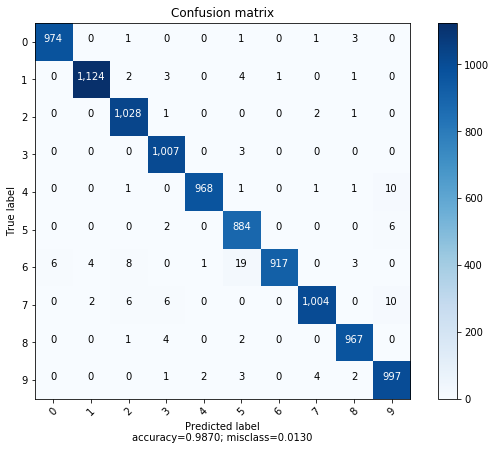

None


In [13]:
from cm_helper import plot_confusion_matrix

conf_matrix = metrics.confusion_matrix(lb, pred)
print(plot_confusion_matrix(conf_matrix,normalize =False,target_names=[0,1,2,3,4,5,6,7,8,9]))